# Проект. Защита персональных данных клиентов страховой компании

## Глава 0. Входные данные

Необходимо защитить данные клиентов страховой компании «Хоть потоп». Разработать метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обосновать корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

#### Путь к файлу:
- /datasets/insurance.csv

#### Описание данных: 
- **Признаки**: пол, возраст и зарплата застрахованного, количество членов его семьи.
- **Целевой признак**: количество страховых выплат клиенту за последние 5 лет.

## Глава 1. Загрузка и изучение  данных

Вызовем все библиотеки, необходимые для реализации проекта:

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

Напишем функцию first_view для ознакомления с таблицой и вызовем ее:

In [28]:
def first_view(df):
    print(df.info()) 
    return df

Прочитаем файл, создадим ДатаФрейм, через функцию выведем информацию и таблицу:

In [29]:
df = pd.read_csv('/datasets/insurance.csv')
first_view(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
Пол                  5000 non-null int64
Возраст              5000 non-null float64
Зарплата             5000 non-null float64
Члены семьи          5000 non-null int64
Страховые выплаты    5000 non-null int64
dtypes: float64(2), int64(3)
memory usage: 195.4 KB
None


,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0
...,...,...,...,...,...
4995,0,28.0,35700.0,2,0
4996,0,34.0,52400.0,1,0
4997,0,20.0,33900.0,2,0
4998,1,22.0,32700.0,3,0


Проверим на дубликаты, вызвав метод `.duplicated()`

In [30]:
df.duplicated().sum()

153

Однако, вариативность данных достаточно низкая и такие дубли можно в действительности получить от разных клиентов. В данном случае оствим без удаления, т.к. по условию задачи нужно защитить данные

Построим гистограммы, чтобы увидеть распределения по признакам. 

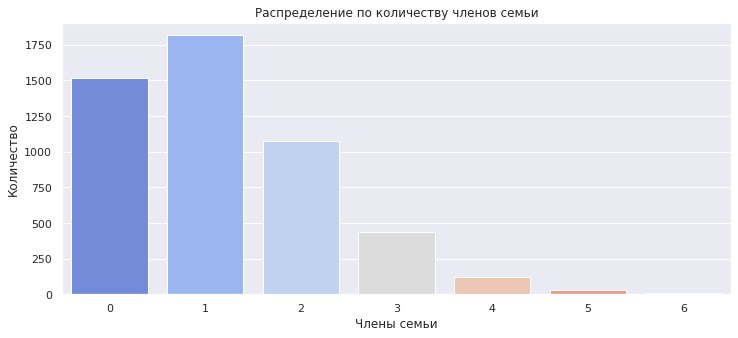

In [31]:
sns.set()
fig, ax = plt.subplots(figsize=(12, 5))
sns.countplot(x='Члены семьи', data=df, palette='coolwarm')
ax.set_title('Распределение по количеству членов семьи')
plt.ylabel('Количество');

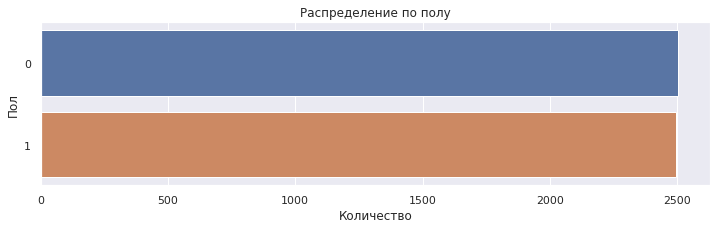

In [32]:
fig, ax = plt.subplots(figsize=(12, 3))
sns.countplot(y='Пол', data=df)
ax.set_title('Распределение по полу')
plt.xlabel('Количество');

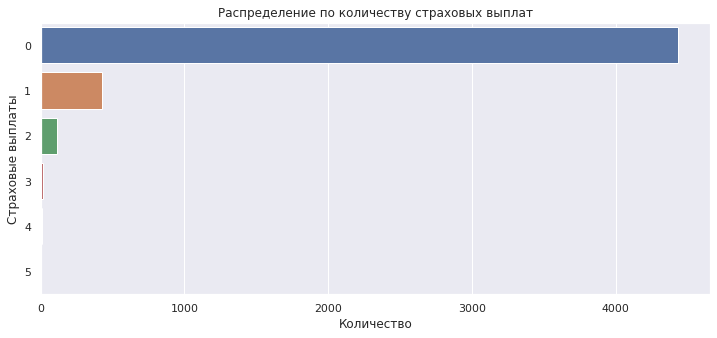

In [33]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.countplot(y='Страховые выплаты', data=df)
ax.set_title('Распределение по количеству страховых выплат')
plt.xlabel('Количество');

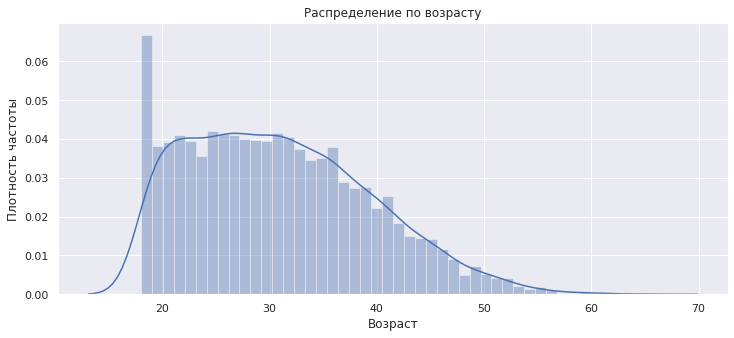

In [34]:
sns.set()
fig, ax = plt.subplots(figsize=(12, 5))
sns.distplot(df['Возраст'], bins=len(df['Возраст'].unique()))
ax.set_title('Распределение по возрасту')
plt.ylabel('Плотность частоты');

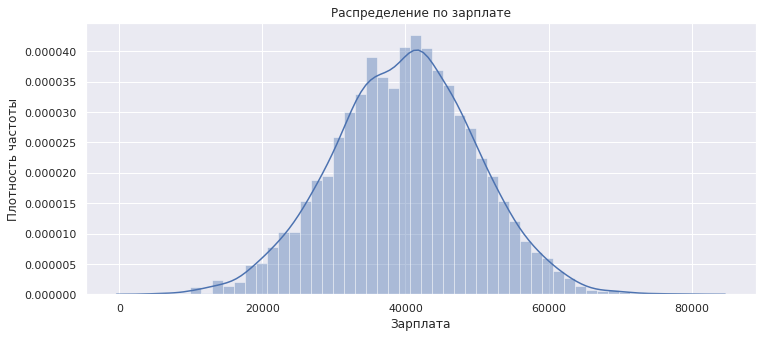

In [35]:
fig, ax = plt.subplots(figsize=(12, 5))
sns.distplot(df['Зарплата'])
ax.set_title('Распределение по зарплате')
plt.ylabel('Плотность частоты');

### Выводы по главе 1:

> - Данные предоставлены в предобработанном виде.
- Признаки распределены без аномалий
- Данные готовы для дальнейших исследований

## Глава 2. Умножение матриц

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

Разделим данные на признаки и целевой признак: `features` и `target`

In [36]:
features = df.drop('Страховые выплаты', axis=1)
target = df['Страховые выплаты']

Создадим класс `LinReg` и напишем 2 метода `fit` и `predict`.  
Первый находит веса w, второй делает предсказания:

In [37]:
class LinReg:
    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)
        y = train_target
        w = np.linalg.inv((X.T @ X)).dot(X.T).dot(y)
        self.w = w[1:]
        self.w0 = w[0]
        print(w)
        
    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0

Создадим модель, сохраним её в переменной model и обучим. Найдем её предсказания на обучающей выборке и сохраним их в переменной predictions. Напечатаем на экране веса и значение метрики R2. Она вычисляется по MSE.

In [38]:
model = LinReg()
model.fit(features, target)
predictions = model.predict(features)
r2_score(target, predictions)

[-9.38235504e-01  7.92580543e-03  3.57083050e-02 -1.70080492e-07
 -1.35676623e-02]


0.4249455028666801

Создадим случайную квадратную матрицу, размером по количеству столбцов `features`

In [39]:
random_matrix = np.random.normal(0, 1, (features.shape[1], features.shape[1]))
random_matrix

array([[-0.95676978,  2.46317982,  0.00767722,  0.02222884],
       [-1.73225004,  1.27540361,  0.18793179,  0.849551  ],
       [-0.56666333,  0.43268564, -1.30968838, -0.70773797],
       [-0.8939173 , -0.77421942,  0.77037265,  1.14178062]])

Пооверим на обратимость, вызвав `np.linalg.inv()`

In [40]:
np.linalg.inv(random_matrix)

array([[ -4.89941505,   6.48259273,  -2.95814991,  -6.56166317],
       [ -1.43385056,   2.43098867,  -1.1128629 ,  -2.47069472],
       [  6.67986868,  -8.86866383,   2.84548961,   8.23254255],
       [ -9.3150775 ,  12.70751687,  -4.99047603, -11.49132281]])

И перемножим исходную на обратную матрицы, должна получиться единичная матрица:

In [41]:
random_matrix @ np.linalg.inv(random_matrix)

array([[ 1.00000000e+00, -9.49797877e-16,  4.55629109e-16,
         8.85478644e-17],
       [-2.45837339e-15,  1.00000000e+00, -1.88935961e-15,
        -1.59203541e-15],
       [-7.02698455e-16,  1.59624046e-15,  1.00000000e+00,
         2.79243350e-16],
       [-1.49949737e-15,  7.12616660e-16, -1.11569579e-15,
         1.00000000e+00]])

Признаки ДатаФрейма умножим на обратимую матрицу `random_matrix`

In [42]:
encoded_features = features.dot(random_matrix)
encoded_features

,0,1,2,3
0,-28179.373885,21515.188005,-64952.060169,-35067.807892
1,-21613.783789,16499.948477,-49758.743032,-26853.821872
2,-11950.165087,9123.385040,-27498.005862,-14837.860467
3,-23668.025760,18068.226017,-54608.517943,-29492.549368
4,-14839.372567,11331.269555,-34177.596832,-18448.151455
...,...,...,...,...
4995,-20280.171557,15481.040032,-46749.072168,-25240.174670
4996,-29752.948676,22715.316777,-68620.510820,-37055.443304
4997,-19246.319571,14692.002660,-44393.136546,-23973.042725
4998,-18571.638767,14177.019666,-42820.356582,-23120.894045


Обучим модель на новых признаках, найдем предсказания, веса и посчитаем R2:

In [43]:
model = LinReg()
model.fit(encoded_features, target)
predictions = model.predict(encoded_features)
r2_score(target, predictions)

[-0.93823993  0.28171771  0.10897645 -0.37549212  0.5359205 ]


0.4249455022404598

#### Как связаны параметры линейной регрессии в исходной задаче и в преобразованной?

Предсказания высчитываются по формуле:

$$
a = Xw
$$

Т.к. новая матрица признаков получается умножением исходной $Х$ на рандомную(обозначим $М$), то формула применит вид:

$$
a = X М w
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

Перепишем формулу нахождения весов $w'$:

$$
w' = ((XM)^T XM)^{-1} (XM)^T y
$$

Раскроем скобки:
$$
w' = ((X^T M^T XM)^{-1} X^T M^T y
$$

$(M^T)^{-1} M^T$ это единичная матрица $E$, матрица умножаясь на единичную равна себе, поэтому сократим запись:

$$
w' =  M^{-1}(X^T X)^{-1} X^T y
$$ 

То есть новые веса $w'$ выражаются через исходные $w$ следующим образом:
$$
w' =  M^{-1} w
$$ 

### Выводы по главе 2:

> Качество линейной регрессии не изменилось.  
Отсюда вытекает следующий вывод:  
- **Ответ:** Умножив признаки на обратимую матрицу, качество линейной регрессии не меняется.  
- **Обоснование:** Веса изменились под новые значения, т.е. признаки исходной матрицы и преобразованной выражаются через коэффициенты(веса w), поэтому качество линейной регресии не изменилось

## Глава 3. Алгоритм преобразования

Напишем алгоритм - функцию преобразования исходных данных в зашифрованный вид, закодировав исходную матрицу:

In [44]:
def encode(features):
    random_matrix = np.random.normal(0, 1, (features.shape[1], features.shape[1]))
    encoded_features = features.dot(random_matrix)
    return encoded_features

In [45]:
encode(features)

,0,1,2,3
0,-102109.016668,7514.866125,35139.628330,9289.232873
1,-78200.120617,5768.484424,26889.448154,7124.867722
2,-43209.409356,3190.667191,14852.531240,3939.436915
3,-85871.499952,6307.930673,29567.535696,7803.199062
4,-53718.363070,3959.133227,18479.268565,4891.108701
...,...,...,...,...
4995,-73495.796504,5407.704677,25293.055942,6685.486488
4996,-107892.338741,7932.604493,37138.496576,9809.840066
4997,-69803.012244,5130.108847,24031.128722,6344.991906
4998,-67324.948065,4949.818515,23178.803550,6120.518951


Для расшифровки данных напишем алгоритм - функцию дешифрования, принимающая на вход зашифрованную матрицу `encoded_features` и возвращающая исходную `features`:

In [46]:
def decode(encoded_features):
    decoded_features = round(abs(encoded_features.dot(np.linalg.inv(random_matrix))))
    for i in decoded_features.iloc[:, [0, 3]]:
        decoded_features[i] = decoded_features[i].astype(int)
    decoded_features.columns = features.columns
    return decoded_features

In [47]:
decode(encoded_features)

,Пол,Возраст,Зарплата,Члены семьи
0,1,41.0,49600.0,1
1,0,46.0,38000.0,1
2,0,29.0,21000.0,0
3,0,21.0,41700.0,2
4,1,28.0,26100.0,0
...,...,...,...,...
4995,0,28.0,35700.0,2
4996,0,34.0,52400.0,1
4997,0,20.0,33900.0,2
4998,1,22.0,32700.0,3


Сравним с оригинальным features:

In [48]:
features

,Пол,Возраст,Зарплата,Члены семьи
0,1,41.0,49600.0,1
1,0,46.0,38000.0,1
2,0,29.0,21000.0,0
3,0,21.0,41700.0,2
4,1,28.0,26100.0,0
...,...,...,...,...
4995,0,28.0,35700.0,2
4996,0,34.0,52400.0,1
4997,0,20.0,33900.0,2
4998,1,22.0,32700.0,3


Данные полностью восстановлены после кодирования

Докажем, почему качество линейной регрессии не поменяется.
Предсказания высчитываются по формуле:

$$
a = Xw
$$

Т.к. новая матрица признаков получается умножением исходной $Х$ на рандомную(обозначим $М$), то формула применит вид:

$$
a' = X М w'
$$

Подставив вычисленное значение весов $w' =  M^{-1} w$ получаем:

$$
a' = X М  M^{-1} w
$$

$М M^{-1}$ это еденичная матрица $E$, т.е. можно сократить:

$$
a' = X w = a
$$

Предсказания по исходной и преобразованной матрицам равны.

### Выводы по главе 3:

> Предложенный алгоритм преобразования данных справляется для решения задачи.  
Качество линейной регрессии не меняется, т.к. новые признаки равны $X М$, а новые веса $w' =  M^{-1} w$, поэтому $a' = X w = a$.
Новые признаки выражаются через исходную, умножив на случайную матрицу, соответственно и новые коэффициенты весов. Но так как оба множителя в произведении выражают исходные через определенные коэффициенты, то качество линейной регресии не измениться. 

## Глава 4. Проверка алгоритма

Проверим, что качество линейной регрессии из sklearn не отличается до и после преобразования. Применим метрику R2.

Создадим модель `sklearn_model` и обучим на 2 обучающих матрицах:  
- исходной `features`  
- кодированной `encoded_features`

In [49]:
sklearn_model = LinearRegression().fit(features, target)
pred = sklearn_model.predict(features)
r2_score(target, pred)

0.42494550286668

In [50]:
sklearn_model.fit(encoded_features, target)
pred = sklearn_model.predict(encoded_features)
r2_score(target, pred)

0.42494550286662003

Качество модели по двум наборам признаков совпадает.

### Выводы по главе 4:

> Качество метрики R2 для 2 матриц признаков: до преобразования и после равны, а также равны R2 по написанному класс линейной регресии `LinReg`, что говорит о ее правильном написании в сравнении с моделью из sklearn.

## Общий вывод:

**Проведенные исследования позволили сделать следующие выводы**:  

*- Умножив признаки на обратимую матрицу, качество линейной регрессии не меняется. Это обусловленно тем, что Веса изменились под новые значения, т.е. признаки исходной матрицы и преобразованной выражаются через коэффициенты(веса w), поэтому качество линейной регресии не изменилось* 

*- Предложенный алгоритм преобразования данных справляется для решения задачи шифрования признаков.*  

*- Зашифрованные данные так же пригодны для предсказаний с помощью линейной регресии*  

*- Алгоритм позволяет дешифровать данные в любой момент*  

*- Случайность реализованная в алгоритме каждый раз меняется при запуске, что делает зашифрованные данные каждый раз новыми. Такой вид исходных данных становиться очень сложно восстановить без кода программы.*  

*- Реализованный алгоритм полностью удовлетворяет поставленной задаче Защиты персональных данных клиентов страховой компании*

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные загружены
- [x]  Выполнен шаг 2: получен ответ на вопрос об умножении матриц
    - [x]  Указан правильный вариант ответа
    - [x]  Вариант обоснован
- [x]  Выполнен шаг 3: предложен алгоритм преобразования
    - [x]  Алгоритм описан
    - [x]  Алгоритм обоснован
- [x]  Выполнен шаг 4: алгоритм проверен
    - [x]  Алгоритм реализован
    - [x]  Проведено сравнение качества моделей до и после преобразования